In [4]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('SK2017_mosinit.hoc')
import hpca_session
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style, rc
import numpy as np
import pickle
style.use("seaborn")
%matplotlib notebook

In [2]:
h.PlotShape(False).plot(plt)

NameError: name 'h' is not defined

In [4]:
h.dend11[10].psection()['density_mechs']

{'pas': {'g': [3.33333e-05], 'e': [-70.0], 'i': [0.0]},
 'cal': {'gcalbar': [0.0001], 'ica': [0.0], 'm': [0.0], 's': [0.0]},
 'hpca': {'gbar': [600.0],
  'ica_pmp': [0.0],
  'ik': [0.0],
  'ca': [[0.0, 0.0, 0.0, 0.0]],
  'HPCA': [[0.0, 0.0, 0.0, 0.0]],
  'CaHPCA': [[0.0, 0.0, 0.0, 0.0]],
  'Ca2HPCA': [[0.0, 0.0, 0.0, 0.0]],
  'HPCA_m': [[0.0, 0.0, 0.0, 0.0]],
  'HPCA_mut': [[0.0, 0.0, 0.0, 0.0]],
  'CaHPCA_mut': [[0.0, 0.0, 0.0, 0.0]],
  'Ca2HPCA_mut': [[0.0, 0.0, 0.0, 0.0]],
  'HPCA_mut_m': [[0.0, 0.0, 0.0, 0.0]],
  'pump': [0.0],
  'pumpca': [0.0],
  'n': [0.0],
  'HPCA_z': [0.0],
  'CaHPCA_z': [0.0],
  'Ca2HPCA_z': [0.0],
  'HPCA_m_z': [0.0],
  'HPCA_tot_z': [0.0],
  'HPCA_mut_z': [0.0],
  'CaHPCA_mut_z': [0.0],
  'Ca2HPCA_mut_z': [0.0],
  'HPCA_mut_m_z': [0.0],
  'HPCA_mut_tot_z': [0.0],
  'Bufer': [[0.0, 0.0, 0.0, 0.0]],
  'CaBufer': [[0.0, 0.0, 0.0, 0.0]]},
 'it2': {'gcabar': [1e-10], 'ica': [0.0], 'm': [0.0], 'h': [0.0]},
 'kca': {'gbar': [3.0], 'gk': [0.0], 'ninf': [0.0], 'ntau

In [9]:
def run_simulation(k_out=0.002, total_protein=0.03821, runtime=1200, color='black'):
    h.TotalHPCA_hpca = total_protein # mM
    h.k8HPCA_hpca = k_out # /ms

    v_soma = h.Vector().record(h.soma(0.5)._ref_v)
    ncs_m = h.Vector().record(h.dend11[10](0.5)._ref_HPCA_m_hpca[0])
    sahpc = h.Vector().record(h.dend11[10](0.5)._ref_ik_hpca)
    time = h.Vector().record(h._ref_t)
    h.finitialize(-70 * mV)
    h.continuerun(runtime * ms)

    plot_timecourse(time, v_soma, label='soma', ylabel='mV', color=color)
    plot_timecourse(time, ncs_m*10**3, label='translocation', ylabel='uM', color=color)
    plot_timecourse(time, sahpc*10**3, label='sAHP current', ylabel='uA',color=color)

def plot_timecourse(time_array, dependent_var, newfigure=True, show=True, label=None, color='black', ylabel=None, constants=None):
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label, color=color, lw=.8)
    plt.xlabel('t (ms)')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.legend()
    if show:
        plt.show()

In [16]:
from random import randint, uniform, seed

class Synapse:
    
    num_synapses = 0
    gmax_AMPA = 0.001 * 100
    gmax_NMDA = 0.7 * 0.001 * 100
    
    stimulator = h.VecStim()
    spike_times = list(range(500, 950, 20)) + list(range(3400, 8950, 60))
    spikes_vector = h.Vector(spike_times)
    
    
    def __init__(self, loc):
        '''Create AMPA/NMDA synapse at given location ('loc' argument)
        '''
        self.loc = loc
        #self.spike_times = list(range(500, 1000, 20)) + list(range(4000, 8000, 60))
        self.GluSyn = h.SimpleAMPA_NMDA(self.loc)
        self.GluSyn.gmax_AMPA = Synapse.gmax_AMPA
        self.GluSyn.gmax_NMDA = Synapse.gmax_NMDA
        Synapse.num_synapses += 1
    
        self.connection = h.NetCon(Synapse.stimulator, self.GluSyn)
        self.connection.weight[0] = 1
    
    
    def __repr__(self):
        return 'Synapse[{}]'.format(self.loc)
        
        
    @classmethod    
    def setup_gmax(cls, gmax_AMPA_new=0, gmax_NMDA_new=0):
        '''updates AMPA and NMDA coductances
        '''
        Synapse.gmax_AMPA = gmax_AMPA_new
        Synapse.gmax_NMDA = gmax_NMDA_new
    
    
    @classmethod
    def play_stimulation(cls):
        '''Presynaptic stimulation of all Synapse instances
        '''
        cls.stimulator.play(cls.spikes_vector)
        
    
    @classmethod
    def restore_defaults(cls):
        '''restore default conductances and synapses counter (num_synapses)
        ''' 
        Synapse.gmax_AMPA = 0.001 * 100
        Synapse.gmax_NMDA = 0.7 * 0.001 * 100
    
    
    @classmethod
    def create_synapses(cls, locs=None, num_rand_locs=None) -> 'synapses instances':
        '''Method for creating  synapses at given locations
        Synapses can be created at given locations
        '''
        Synapse.restore_defaults()
        if locs:
            Synapse.setup_gmax(gmax_AMPA_new = Synapse.gmax_AMPA / len(locs),
                               gmax_NMDA_new = Synapse.gmax_NMDA / len(locs))
            syns = [cls(h.dend11[loc](0.5)) for loc in locs]
            return syns
        if num_rand_locs:
            seed(245)
            if num_rand_locs > 300:
                raise ValueError('No more than 300 synapses are allowed. %s were given' % num_rand_locs)
            
            # changes NMDA and AMPA coductance proportionally to num_rand_locs
            # to satisfy constant total coductanca for any no. of synapses
            Synapse.setup_gmax(gmax_AMPA_new = Synapse.gmax_AMPA / num_rand_locs,
                               gmax_NMDA_new = Synapse.gmax_NMDA / num_rand_locs)  
            syns = [cls(h.dend11[randint(12, 82)](uniform(0, 1))) for i in range(num_rand_locs)] 
            return syns

0.005


<IPython.core.display.Javascript object>


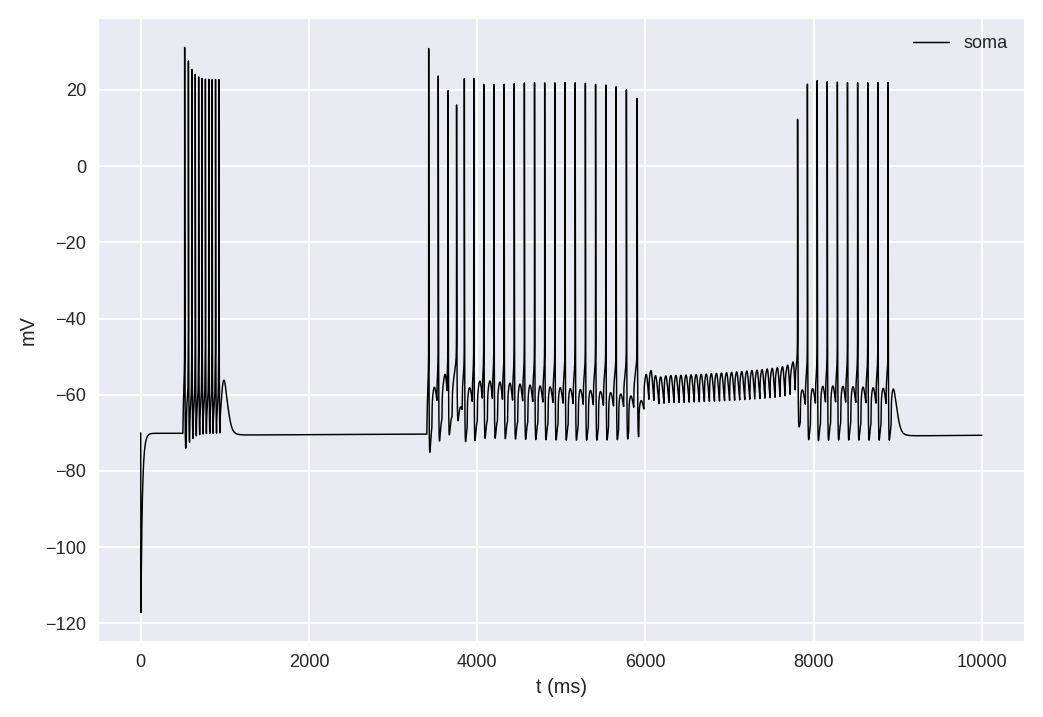

<IPython.core.display.Javascript object>


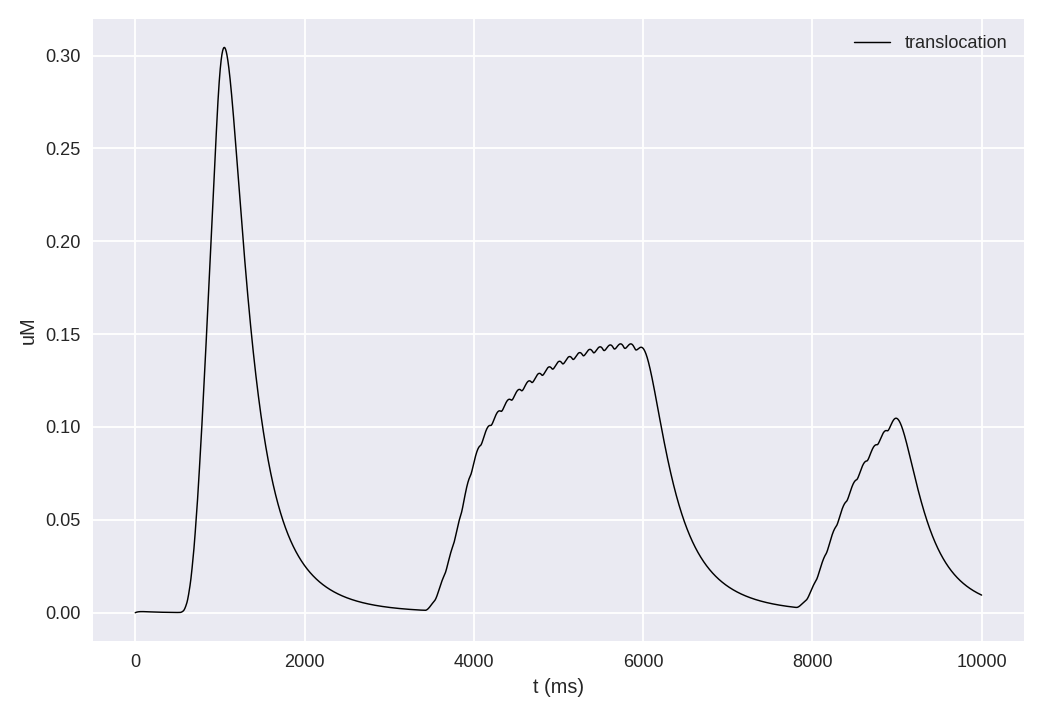

<IPython.core.display.Javascript object>


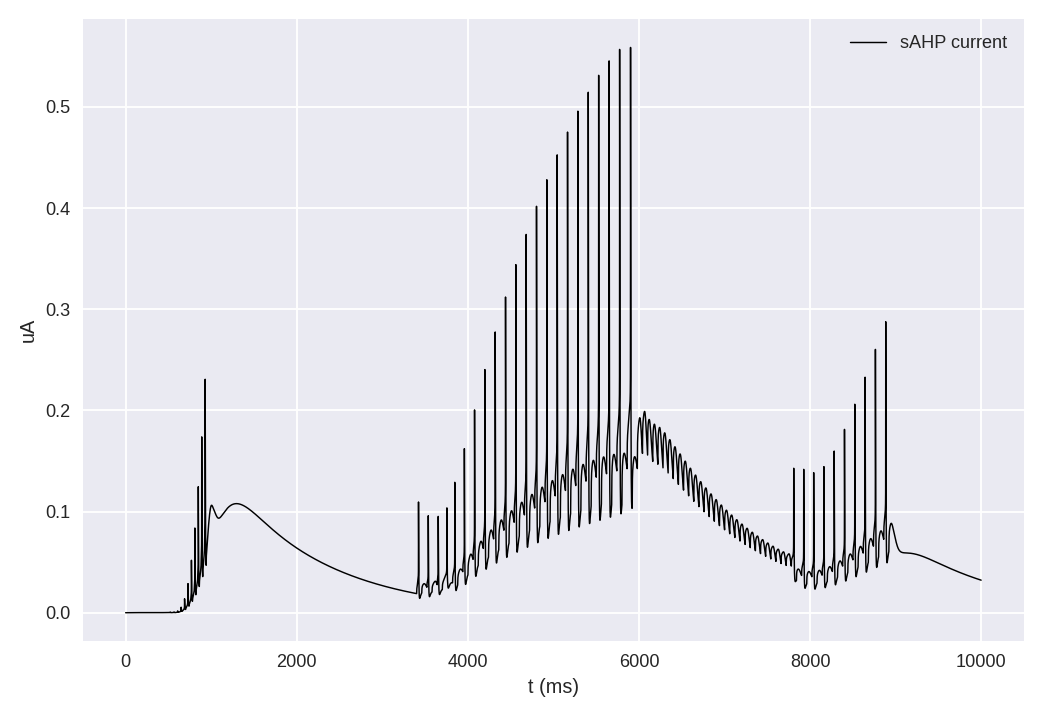

In [17]:
synapses = Synapse.create_synapses(num_rand_locs=20)
Synapse.play_stimulation()
print(Synapse.gmax_AMPA)  
run_simulation(k_out=0.02, runtime=10000, color='black')

In [14]:
h.celsius

23.0

In [7]:
del synapses
del syn_

NameError: name 'syn_' is not defined

In [ ]:
del syn_
syn_ = h.AlphaSynapse(h.dend11[58](0.3125))
syn_.gmax = 0.1 # us
syn_.onset = 4000
syn_.tau = 100

In [ ]:
plt.figure()
for i, col in zip([0.002,  7.7e-5], ['black', 'red']):
    run_simulation(k_out=i, total_protein=0.03821, runtime=10000, color=col)
plt.show()

In [ ]:
print([item for item in dir(syn_) if not item.startswith('__')])
print(syn_.loc)

## Diameter influence on translocation

In [ ]:
h.k8HPCA_hpca = 0.02
ncs_m = h.Vector().record(h.dend11[10](0.5)._ref_HPCA_m_hpca[0])
t = h.Vector().record(h._ref_t)

plt.figure(dpi=125)
for j in range(1, 4):
    for i in range(10, 21):
        sec = h.dend11[i]
        print(sec.diam)
        sec.diam *= 1.1
    h.finitialize()
    h.continuerun(4000 * ms)
    plt.plot(t, ncs_m, label=round(h.dend11[10].diam, 1))

plt.xlabel('time [ms]')
plt.ylabel('uM')
plt.legend(title='Diam, um')
plt.show()